In [1]:
import sys
sys.path.insert(0, '/home/jpmarceaux/Applications/pyGSTi')
import numpy as np
import pygsti as pig
import pygsti.objects as po
import pygsti.construction as pc
from pygsti.objects import Circuit
from pygsti.objects import Label
import matplotlib.pyplot as plt
import random
import time
import pandas

In [3]:
# allocate a non-local 2-qubit model
# the model is a dictionary of lists of error generators
cut_set = []
rows, cols = ideal_model['Gcx10'].shape
for i in range(rows):
    for j in range(cols):
        unit_mat = np.zeros((rows, cols))
        unit_mat[i,j] = 1
        cut_set.append(unit_mat)

nonlocal_2qubit_model = dict()
for lbl in labels:
    nonlocal_2qubit_model[lbl] = cut_set.copy()
    
print(nonlocal_2qubit_model.keys())

dict_keys(['Gx0', 'Gy0', 'Gx1', 'Gy1', 'Gcx01', 'Gcx10'])


In [4]:
# allocate a local model
# the model is a dictionary of lists of error generators

two_qubit_units= []
for i in range(16):
    for j in range(16):
        unit_mat = np.zeros((16, 16))
        unit_mat[i,j] = 1
        two_qubit_units.append(unit_mat)
        
qubit0_units = []
qubit1_units = []
for i in range(4):
    for j in range(4):
        unit_mat = np.zeros((4, 4))
        unit_mat[i,j] = 1
        qubit0_units.append(np.kron(unit_mat, np.eye(4)))
        qubit1_units.append(np.kron(np.eye(4), unit_mat))

local_2qubit_units = dict()
for lbl in labels:
    if (lbl == "Gcx01") or (lbl == "Gcx10"):
        local_2qubit_units[lbl] = two_qubit_units.copy()
    elif (lbl == "Gx0") or (lbl == "Gy0"):
        local_2qubit_units[lbl] = qubit0_units.copy()
    elif (lbl == "Gx1") or (lbl == "Gy1"):
        local_2qubit_units[lbl] = qubit1_units.copy()
    
print(local_2qubit_units.keys())

dict_keys(['Gx0', 'Gy0', 'Gx1', 'Gy1', 'Gcx01', 'Gcx10'])


In [5]:
def create_matrix_units(num_qubits):
    """
    create an array of matrix units
    """
    matrix_units = []
    for i in range(4**num_qubits):
        for j in range(4**num_qubits):
            unit_mat = np.zeros((4**num_qubits, 4**num_qubits))
            unit_mat[i,j] = 1
            matrix_units.append(unit_mat)
    return matrix_units

In [6]:
def make_rho0(qubits):
    """Return |0>^n in Pauli basis"""
    rho = np.zeros((4**qubits), dtype=complex)
    rho[0] = 1
    return pig.tools.change_basis(rho, 'std', 'pp')

In [7]:
def compile_circuit_with_idle(label_list, qubits):
    """
    compile a label list into a circuit, padding the circuit with idle operations
    """
    layers = []
    for lbl in label_list:
        if lbl == 'cx01':
            layers.append(Label('Gcx01', [0, 1]))
        elif lbl == 'cx10':
            layers.append(Label('Gcx10', [1, 0]))
        elif lbl == 'I':
            layers.append(Label('Gi01'))
        elif lbl == 'x0':
            layers.append([Label('Gx0', 0), Label('Gi1', 1)])
        elif lbl == 'y0':
            layers.append([Label('Gy0', 0), Label('Gi1', 1)])
        elif lbl == 'x1':
            layers.append([Label('Gx1', 1), Label('Gi0', 0)])
        elif lbl == 'y1':
            layers.append([Label('Gy1', 1), Label('Gi0', 0)])
    return Circuit(layers, line_labels=qubits)

In [149]:
def compile_circuit(label_list, qubits):
    """
    compile a label list into a circuit, without idle operations
    """
    layers = []
    for lbl in label_list:
        if lbl == 'cx01':
            layers.append(Label('Gcx01', ['0', 1]))
        elif lbl == 'cx10':
            layers.append(Label('Gcx10', [1, 0]))
        elif lbl == 'I':
            layers.append(Label('Gi01'))
        elif lbl == 'x0':
            layers.append(Label('Gx0', 0))
        elif lbl == 'y0':
            layers.append(Label('Gy0', 0))
        elif lbl == 'x1':
            layers.append(Label('Gx1', 1))
        elif lbl == 'y1':
            layers.append(Label('Gy1', 1))
    return Circuit(layers, line_labels=qubits)

In [150]:
def compile_circuit_hetero2homo(label_list, qubits):
    """
    compile a label list into a circuit, without idle operations
    """
    layers = []
    for lbl in label_list:
        if lbl == 'cx01':
            layers.append(Label('Gcnot', ['0', 1]))
        elif lbl == 'cx10':
            layers.append(Label('Gcnot', [1, 0]))
        elif lbl == 'I':
            layers.append(Label('Gi'))
        elif lbl == 'x0':
            layers.append(Label('Gx', 0))
        elif lbl == 'y0':
            layers.append(Label('Gy', 0))
        elif lbl == 'x1':
            layers.append(Label('Gx', 1))
        elif lbl == 'y1':
            layers.append(Label('Gy', 1))
        elif lbl == 'z0':
            layers.append(Label('Gz', 0))
        elif lbl == 'z1':
            layers.append(Label('Gz', 1))
    return Circuit(layers, line_labels=qubits)

In [151]:
def create_random_hetero_circuit(width, depth, key_list):
    layers = []
    for i in range(depth):
        layers.append(random.choice(key_list))
    return compile_circuit(layers, [i for i in range(width)])

def create_random_homo_circuit(width, depth, key_list):
    layers = []
    for i in range(depth):
        layers.append(random.choice(key_list))
    return compile_circuit_hetero2homo(layers, [i for i in range(width)])

def create_hetero_and_homo_circuit(width, depth, key_list):
    layers = []
    for i in range(depth):
        layers.append(random.choice(key_list))
    return [compile_circuit(layers, [i for i in range(width)]), compile_circuit_hetero2homo(layers, [i for i in range(width)])]

In [152]:
def create_layers(circ, explicit_model):
    layers_out = []
    n_qubits = circ.width
    for idx in range(0, circ.depth):
        new_layer = np.eye(4**n_qubits)
        for element in circ[idx]:
            if type(element) is Label:
                for el in element:
                    new_layer = explicit_model[el]@new_layer
                break
            else:
                new_layer = explicit_model[element]@new_layer
                break
        layers_out.append(new_layer)
    return layers_out

In [153]:
def create_circ_process(circ, explicit_model):
    """
    return process matrix representing the circuit
    """
    layers = create_layers(circ, explicit_model)
    pmat = layers[0]
    for idx in range(1, len(layers)):
        pmat = layers[idx]@pmat 
    return pmat

In [172]:
def calculate_pvec(circ, explicit_model, rho):
    """
    calculate probability of outcomes in computational basis
    """
    n_qubits = circ.width
    povm = po.ComputationalBasisPOVM(n_qubits, 'densitymx')
    
    
    circ_process = create_circ_process(circ, explicit_model)
    pvec_out = np.zeros(2**n_qubits)
    for mu in range(2**n_qubits):
        key = format(mu, '0'+str(n_qubits)+'b')
        pvec_out[mu] = povm[key].to_dense()@circ_process@rho
    return pvec_out
        

In [173]:
def make_probvec(circ, model):
    """Make a probability vector of circuit outcomes under a given model"""
    qubits = circ.width
    p = circ.simulate(model)
    vecout = np.zeros(2**qubits)
    for key in p.keys():
        vecout[int(key[0], 2)] = p[key]
    return(vecout)

In [174]:
def create_model_rows(circ, generator_map, gate_labels, ideal_model, rho):
    """
    create 2^n model rows from the circut outcomes
    
    using feature convention [gates, measurement, prep]
    """
    n_qubits = circ.width
    rho0 = make_rho0(n_qubits)
    cmat = create_circ_process(circ, ideal_model)
    povm = po.ComputationalBasisPOVM(n_qubits, 'densitymx')
    
     # [1] make initialization tensor 
    A_initial = cmat@rho0 
    
    # [2] make gate and readout tensors
    A_readout = []
    A_gates = []
    
    for idx, key in enumerate(povm.keys()):
        # [2.1] readout design vectors
        E = povm[key]
        A_readout_mu = E.to_dense()@cmat
        A_readout.append(A_readout_mu)
        
        # [2.2] circuit design matrices
        g_mats_mu = dict()
        
        # allocate
        for g_lbl in gate_labels:
            g_mats_mu[g_lbl] = np.zeros(len(generator_map[g_lbl]))
        
        # calculate
        for c_idx, c in enumerate(circ):
            g_mats_mu[c.name] += create_error_cut(c_idx, circ, generator_map, ideal_model, E, rho)
            
        A_gates.append(
            np.concatenate([g_mats_mu[g_lbl].flatten() for g_lbl in gate_labels])
        )
        
    # [3] form tensors into rows
    # Use the ordering [gates, readout, initialization]
    # we must pad initialization features with zeros for the differnt circuit outcomes
    L_initial = A_initial.size
    N_mu = len(povm) # number of different measurement outcomes
    
    rows = []
    for n in range(N_mu):
        A_initial_padded = np.concatenate((np.zeros(L_initial*n), A_initial, np.zeros(L_initial*(N_mu-n-1))))
        row = np.concatenate((A_gates[n], A_readout[n], A_initial_padded))
        rows.append(row)
    return rows

In [175]:
def create_model_features_1qb(circ, generator_map, gate_labels, ideal_model, rho):
    """
    create model feature vector dictionaries
    """
    n_qubits = circ.width
    rho0 = make_rho0(n_qubits)
    cmat = create_circ_process(circ, ideal_model)
    povm = po.ComputationalBasisPOVM(n_qubits, 'densitymx')
    
    features = dict()
    
     # [1] make initialization tensor 
    A_initial = cmat@rho0 
    features['prep'] = A_initial.flatten()
    
    # [2] make gate and readout tensors
    A_readout = []
    A_gates = []
    
    for idx, key in enumerate(povm.keys()):
        # [2.1] readout design vectors
        E = povm[key]
        A_readout_mu = E.to_dense()@cmat
        features["ro:"+key] = A_readout_mu.flatten()
        
        # [2.2] circuit design matrices
        g_mats_mu = dict()
        
        # allocate
        for g_lbl in gate_labels:
            g_mats_mu[g_lbl] = np.zeros(len(generator_map[g_lbl]))
        
        # calculate
        for c_idx, c in enumerate(circ):
            g_mats_mu[c.name] += create_error_cut(c_idx, circ, generator_map, ideal_model, E, rho)
        
        for gate_key in g_mats_mu.keys():
            features[gate_key+"+"+key] = g_mats_mu[gate_key].copy()
        
    return features

In [176]:
def create_error_cut(n_layer, circ, generator_map, ideal_model, E_mu, rho):
    """
    create an error cut from the error generators at a layer in the circuit 
    """
    nbits = circ.width
    layer_label = circ.tup[n_layer][0]
    error_gens = generator_map[layer_label]
    
    prefactor = rho
    postfactor = E_mu.to_dense().T
    
    for i in range(n_layer+1):
        prefactor = ideal_model[circ.tup[i][0]]@prefactor
    for j in range(n_layer+1, circ.depth):
        postfactor = postfactor@ideal_model[circ.tup[j][0]]
    
    cut_out = np.zeros(len(error_gens))
    for idx, egen in enumerate(error_gens):
        cut_out[idx] = postfactor@egen@prefactor
    
    return cut_out

In [206]:
def create_model_tensors(circ, generator_map, gate_labels, ideal_model, rho):
    """
    create model feature tensors from the circut outcomes
    
    using feature convention [gates, prep, measurement]
    """
    n_qubits = circ.width
    povm = po.ComputationalBasisPOVM(n_qubits, 'densitymx')
    
    # count model degrees of freedom
    n_dof_gates = 0
    for gate in gate_labels:
        n_dof_gates += len(generator_map[gate])
    n_dof = 2**n_qubits*(n_dof_gates + 2*4**(2*n_qubits))
    
    # populate parameter map and feature ranges
    """
    The parameter map is a function from parameters to matrices 
    that outputs the process generator associated with each index
    
    The feature ranges are maps from measurements to ranges in parameter space
    """
    parameter_map = dict()
    feature_ranges = []
    units = create_matrix_units(n_qubits)
    n_current = 0
    for mu in range(2**n_qubits):
        measurement_range = dict()
        # gates
        for g_lbl in gate_labels:
            range_0 = n_current
            for generator in generator_map[g_lbl]:
                parameter_map[n_current] = generator
                n_current += 1
            measurement_range[g_lbl] = range(range_0, n_current, 1)
        # prep errors
        range_0 = n_current
        for u in units:
            parameter_map[n_current] = u.copy()
            n_current += 1
        measurement_range['prep'] = range(range_0, n_current, 1)
        # measurement errors
        range_0 = n_current
        for u in units:
            parameter_map[n_current] = u.copy()
            n_current += 1
        measurement_range['meas'] = range(range_0, n_current, 1)
        feature_ranges.append(measurement_range.copy())
    
    # construct the design tensors
    tensor_list = []

    
    # right now, just do the order-1 and order-2 tensors
    vector_tensors = []
    matrix_tensors = []
    
    # order-1 tensors
    for mu, key in enumerate(povm.keys()):
        vector_tensor = np.zeros([n_dof], dtype=np.float64)
        matrix_tensor = np.zeros([n_dof, n_dof], dtype=np.float64)
        
        # design tensor associated with this measurement 
        E_mu = povm[key]
        
        # order-1 gate factors + order-2 spam factors
        for idx1, layer1 in enumerate(circ):
            g_lbl1 = circ.tup[idx1][0]
            factors = [
                np.eye(4**n_qubits), 
                np.eye(4**n_qubits)
            ]
            for i in range(0, idx1+1):
                factors[0] = ideal_model[circ.tup[i][0]]@factors[0]
            for i in range(idx1+1, circ.depth):
                factors[1] = ideal_model[circ.tup[i][0]]@factors[1]

            for param1 in feature_ranges[mu][g_lbl1]:
                inner_factor = factors[0]@parameter_map[param1]@factors[1]
                vector_tensor[param1] += (
                    E_mu.to_dense()@
                    inner_factor@
                    rho
                )
                for param_spam in feature_ranges[mu]['meas']:
                    matrix_tensor[param1, param_spam] += (
                        E_mu.to_dense()@
                        parameter_map[param_spam]@
                        inner_factor@
                        rho
                    )
                for param_spam in feature_ranges[mu]['prep']:
                    matrix_tensor[param1, param_spam] += (
                        E_mu.to_dense()@
                        inner_factor@
                        parameter_map[param_spam]@
                        rho
                    ) 
                    
        # order-1 spam factors
        circ_process = np.eye(4**n_qubits)
        for i in range(0, circ.depth):
            circ_process = ideal_model[circ.tup[i][0]]@circ_process
        for param in feature_ranges[mu]['meas']:
            vector_tensor[param] += (
                E_mu.to_dense()@
                circ_process@
                parameter_map[param]@
                rho
            )
        for param in feature_ranges[mu]['prep']:
            vector_tensor[param] += (
                E_mu.to_dense()@
                circ_process@
                parameter_map[param]@
                rho
            )
            
        # order-2 gate features
        for idx1, layer1 in enumerate(circ):
            for idx2, layer2 in enumerate(circ):
                g_lbl1 = circ.tup[idx1][0]
                g_lbl2 = circ.tup[idx2][0]
                factors = [
                    np.eye(4**n_qubits), 
                    np.eye(4**n_qubits), 
                    np.eye(4**n_qubits)
                ]
                for i in range(0, idx1+1):
                    factors[0] = ideal_model[circ.tup[i][0]]@factors[0]
                for i in range(idx1+1, idx2+1):
                    factors[1] = ideal_model[circ.tup[i][0]]@factors[1]
                for i in range(idx2+1, circ.depth):
                    factors[2] = ideal_model[circ.tup[i][0]]@factors[2]
                    
                for param1 in feature_ranges[mu][g_lbl1]:
                    for param2 in feature_ranges[mu][g_lbl2]:
                        matrix_tensor[param1, param2] += (
                            E_mu.to_dense()@
                            factors[0]@
                            parameter_map[param1]@
                            factors[1]@
                            parameter_map[param2]@
                            factors[2]@
                            rho
                        )           
        vector_tensors.append(vector_tensor)
        matrix_tensors.append(matrix_tensor)
    return [vector_tensors, matrix_tensors]

In [207]:
qubits = [0, 1]
hetero_labels = ['Gx0','Gy0','Gx1','Gy1','Gcx01', 'Gcx10']
hetero_actions = ["X(pi/2,0)", "Y(pi/2,0)", "X(pi/2,1)", "Y(pi/2,1)", 'CX(pi,0,1)', 'CX(pi,1,0)'] 

hetero_model = pc.create_explicit_model( 
    qubits, 
    hetero_labels, n n 
    hetero_actions, 
)

SyntaxError: invalid syntax (<ipython-input-207-fbb528cea304>, line 7)

In [208]:
# allocate a local, hetero model
# the model is a dictionary of lists of error generators

two_qubit_units= []
for i in range(16):
    for j in range(16):
        unit_mat = np.zeros((16, 16))
        unit_mat[i,j] = 1
        two_qubit_units.append(unit_mat)
        
qubit0_units = []
qubit1_units = []
for i in range(4):
    for j in range(4):
        unit_mat = np.zeros((4, 4))
        unit_mat[i,j] = 1
        qubit0_units.append(np.kron(unit_mat, np.eye(4)))
        qubit1_units.append(np.kron(np.eye(4), unit_mat))

local_2qubit_hetero_units = dict()
for lbl in hetero_labels:
    if (lbl == "Gcx01") or (lbl == "Gcx10"):
        local_2qubit_hetero_units[lbl] = two_qubit_units.copy()
    elif (lbl == "Gx0") or (lbl == "Gy0"):
        local_2qubit_hetero_units[lbl] = qubit0_units.copy()
    elif (lbl == "Gx1") or (lbl == "Gy1"):
        local_2qubit_hetero_units[lbl] = qubit1_units.copy()
    
print(local_2qubit_hetero_units.keys())

dict_keys(['Gx0', 'Gy0', 'Gx1', 'Gy1', 'Gcx01', 'Gcx10'])


In [209]:
nQubits = 2
gate_ordering = ['Gx', 'Gy', 'Gcnot']
ideal_model = pig.construction.create_crosstalk_free_model(
            nQubits, gate_names=gate_ordering)
noise_model = pig.construction.create_crosstalk_free_model(
            nQubits, gate_names=gate_ordering, 
            depolarization_strengths={
                'Gx':0.001,
                'Gy':0.001,
                'Gcnot':0.001
            })

In [210]:
def random_1qb_circ_xyz(depth):
    layers = []
    for n in range(depth):
        i = random.randint(1, 3)
        if i == 1:
            layers.append(Label('Gx', 0))
        elif i == 2:
            layers.append(Label('Gy', 0))
        elif i == 3:
            layers.append(Label('Gz', 0))
    return Circuit(layers, [0])

In [211]:
def ek_filter(N, depth, n_qubits, ideal_model, generator_map, noise_model, gate_labels, gate_seeds):
    povm = po.ComputationalBasisPOVM(n_qubits, 'densitymx')
    rho0 = make_rho0(n_qubits)
    
    # count model degrees of freedom
    n_dof_gates = 0
    for gate in gate_labels:
        n_dof_gates += len(generator_map[gate])
    n_dof = 2**n_qubits*(n_dof_gates + 2*4**(2*n_qubits))
    
    evec = np.zeros(n_dof)
    
    Q = 0.1*np.eye(n_dof)
    R = 0.1*np.eye(2**n_qubits)
    
    P = np.zeros(Q.shape)
    
    for n in range(N):
        circ = random_1qb_circ_xyz(depth)
        p_ideal = calculate_pvec(circ, ideal_model, rho0)
        p_noisy = make_probvec(circ, noise_model)
        y_n = p_noisy-p_ideal
        
        V, M = create_model_tensors(circ, generator_map, gate_labels, ideal_model, rho0)
        jacob = V + M@evec
        
        y_predict = V@evec + evec.T@M@evec
        cov_predict = P + Q
        
        residual = y_n - y_predict
        # print(np.linalg.norm(residual))
        
        K = P@jacob.T@np.linalg.inv(jacob@cov_predict@jacob.T + R)
        
        evec = evec + K@residual
        P = (np.eye(n_dof) - K@jacob)@cov_predict
    return evec

In [233]:
def validate_1qb(N, evec_filter, depth, generators, ideal_model, noise_model, gate_labels):
    povm = po.ComputationalBasisPOVM(1, 'densitymx')
    
    filter_errors = []
    direct_errors = []
    rho0 = make_rho0(1)
    p_filter = np.zeros(N)
    p_exact = np.zeros(N)
    
    for n in range(N-1):
        circ = random_1qb_circ_xyz(depth)

        V, M = create_model_tensors(circ, generators, gate_labels, ideal_model, rho0)
        p_ideal = calculate_pvec(circ, ideal_model, rho0)
        p_noisy = make_probvec(circ, noise_model)
        p_delta = p_noisy-p_ideal
        
        prediction_filter = V@evec + evec.T@M@evec
        pred_error_filter = np.linalg.norm(prediction_filter - p_delta)
        
        filter_errors.append(pred_error_filter)
        
        direct_error = np.linalg.norm(p_noisy - p_ideal)
        direct_errors.append(direct_error)
        
        p_filter[n] = prediction_filter[0]
        p_exact[n] = p_noisy[0] - p_ideal[0]
        
        #plt.scatter(n, pred_error_filter, color='green')
        #plt.scatter(n, direct_error, color='red')
    data = {
        'Direct Errors' : direct_errors,
        'Filter Errors' : filter_errors, 
    }
    df = pandas.DataFrame(data)
    print('mean\n', df.mean())
    print('var\n', df.var())
    plt.scatter(p_filter, p_exact)
    plt.show()

In [213]:
qubits_1qb = [0]
labels_1qb = ['Gx','Gy','Gz']
actions_1qb = ["X(pi/2,0)", "Y(pi/2,0)", "Z(pi/2,0)",] 

ideal_model_1qb = pc.create_explicit_model( 
    qubits_1qb, 
    labels_1qb, 
    actions_1qb, 
)

In [214]:
gate_ordering_1qb = ['Gx', 'Gy', 'Gz']
noise_model_1qb = pig.construction.create_crosstalk_free_model(
            1, gate_names=gate_ordering_1qb, 
            depolarization_strengths={
                'Gx':0.001,
                'Gy':0.001,
                'Gz':0.001
            })

In [215]:
# allocate a set of 1-qubit units
qubit_units = []
for i in range(4):
    for j in range(4):
        unit_mat = np.zeros((4, 4))
        unit_mat[i,j] = 1
        qubit_units.append(unit_mat)

generators_1qubit_xyz = dict()
for lbl in labels_1qb:
    generators_1qubit_xyz[lbl] = qubit_units.copy()
    
print(generators_1qubit_xyz.keys())

dict_keys(['Gx', 'Gy', 'Gz'])


In [216]:
evec = ek_filter(100, 8, 1, ideal_model_1qb, generators_1qubit_xyz, noise_model_1qb, labels_1qb, ['x0', 'y0', 'z0'])

mean
 Direct Errors    0.003217
Filter Errors    0.000463
dtype: float64
var
 Direct Errors    1.409014e-05
Filter Errors    2.459643e-07
dtype: float64


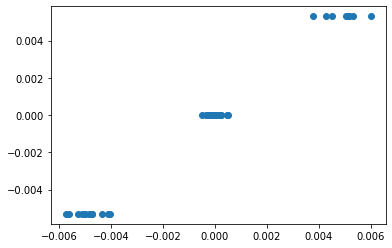

In [234]:
validate_1qb(50, evec, 8, generators_1qubit_xyz, ideal_model_1qb, noise_model_1qb, labels_1qb)